In [66]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Nadam
import matplotlib.pyplot as plt

np.random.seed(88)
tf.random.set_seed(88)

# 9) Build your own CNN from scratch and try to achive highest possible accuracy on MNIST.

In [130]:
(X_train_full, y_train), (X_test, y_test) = mnist.load_data()

validation_size = 5000
X_train, y_train = X_train_full[:-validation_size], y_train[:-validation_size]
X_valid, y_valid = X_train_full[-validation_size:], y_train[-validation_size:]

X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Showing image of a 7


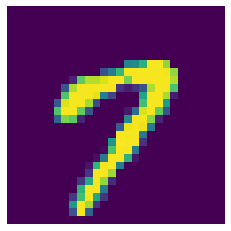

In [177]:
print(f'Showing image of a {y_train[15]}')
digit = X_train[15].reshape(28, 28)
plt.imshow(digit)
plt.axis('off')
plt.show()

In [178]:
print('Input has shape')
X_train.shape

Input has shape


(55000, 28, 28, 1)

In [179]:
print('These are the possible output classes')
np.unique(y_train, axis=0)

These are the possible output classes


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [189]:
activation = 'elu'
model_params = {
    'activation': activation,
    'padding': 'SAME',
    'kernel_initializer':'he_normal'
}
optimizer_params = {
    'optimizer': Nadam(learning_rate=0.001),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}
train_params = {
    'epochs': 5,
    'batch_size': 32,
    'validation_data': (X_valid, y_valid)
}

Let's first build a basic dense model to establish a baseline

In [190]:
dense_model = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(100, activation=activation),
    Dense(200, activation=activation),
    Dense(10, activation='softmax')])
dense_model.compile(**optimizer_params)
dense_model.summary()
dense_model.fit(X_train, y_train, **train_params)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_47 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_144 (Dense)            (None, 200)               20200     
_________________________________________________________________
dense_145 (Dense)            (None, 10)                2010      
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2757 - accuracy: 0.9191 - val_loss: 9.9726 - val_accuracy: 0.0980
Epoch 2/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1277 - accuracy: 0.9612 -

And let's check how it performs against the test set

In [191]:
dense_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0824 - accuracy: 0.9750


[0.08238860219717026, 0.9750000238418579]

Now for using convolutional layers

In [192]:
model = Sequential([
    Conv2D(32, 3, input_shape=X_train.shape[1:], **model_params),
    MaxPool2D(2),
    Conv2D(64, 3, **model_params),
    MaxPool2D(2),
    Flatten(),
    Dense(64, activation=activation),
    Dropout(0.3),
    Dense(32, activation=activation),
    Dropout(0.5),
    Dense(10, activation='softmax')])
model.compile(**optimizer_params)
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_146 (Dense)            (None, 64)                200768    
_________________________________________________________________
dropout_67 (Dropout)         (None, 64)              

In [193]:
model.fit(X_train, y_train, **train_params)

Epoch 1/5
1719/1719 [==============================] - 40s 23ms/step - loss: 0.2890 - accuracy: 0.9218 - val_loss: 14.4607 - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.1172 - accuracy: 0.9712 - val_loss: 18.7163 - val_accuracy: 0.0972
Epoch 3/5
1719/1719 [==============================] - 35s 20ms/step - loss: 0.0905 - accuracy: 0.9771 - val_loss: 19.0885 - val_accuracy: 0.0972
Epoch 4/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.0781 - accuracy: 0.9810 - val_loss: 22.0263 - val_accuracy: 0.0980
Epoch 5/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.0676 - accuracy: 0.9826 - val_loss: 24.2998 - val_accuracy: 0.0982


And evaluating

In [195]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0595 - accuracy: 0.9850


[0.059456054121255875, 0.9850000143051147]

Better results!

# 10) Use transfer learning for large image classification
## a) Create your own dataset or use an existing one

Let's use Horses Or Humans, cause [you know..](http://www.laurencemoroney.com/horses-or-humans-dataset/)

In [71]:
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model

In [16]:
dataset, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True)

In [18]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    version=3.0.0,
    description='A large set of images of horses and humans.',
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=1283,
    splits={
        'test': 256,
        'train': 1027,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
    redistribution_info=,
)

Get some meta info

In [115]:
class_names = info.features['label'].names
n_classes = len(class_names)
print(f'{class_names}')

['horses', 'humans']


The dataset has two classes, so we'll use binary_crossentropy as loss and our last layer will have 1 neuron

Now load the data already split

In [40]:
test_raw, valid_raw, train_raw = tfds.load('horses_or_humans', as_supervised=True,
                                           split=['test[:70%]', 'train[70%:]', 'train'])

In [104]:
def preprocess(image, label, keras_app=keras.applications.densenet):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras_app.preprocess_input(resized_image)
    return final_image, label

In [105]:
batch_size = 32
train_set = train_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_raw.map(preprocess).batch(batch_size).prefetch(1)

Let's have a look at what the images look like. (not sure why the brightness is very high, set alpha to reduce it)

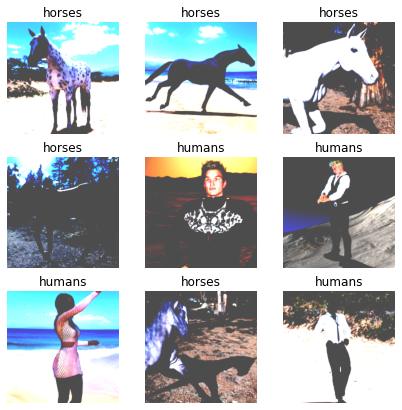

In [147]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7,7))

for img, label in train_set.take(1):
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(img[idx], alpha=0.7)
        ax.axis('off')
        ax.set_title(f'{class_names[label[idx]]}')

Now we load a pre-trained model without the head i.e. the GlobalAvg pooling layer and the fully connected layer after that. We'll insert our own for training.

In [106]:
base_model = keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False)

In [107]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

Now we construct the model head using the functional API

In [111]:
avg_pool = GlobalAveragePooling2D()(base_model.output)
dense1 = Dense(100, activation='relu')(avg_pool)
dense2 = Dense(100, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=base_model.input, outputs=output)

In [112]:
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [113]:
model.fit(train_set, epochs=2, validation_data=valid_set)

Epoch 1/2
33/33 [==============================] - 156s 5s/step - loss: 0.0925 - accuracy: 0.9834 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 2/2
33/33 [==============================] - 153s 5s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.7231e-04 - val_accuracy: 1.0000


In [114]:
model.evaluate(test_set)

6/6 [==============================] - 17s 3s/step - loss: 0.0012 - accuracy: 1.0000


[0.0011637699790298939, 1.0]